In [1]:
# importing necessary modules.
import pandas as pd
import config6 as cfg
from sqlalchemy import create_engine
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

In [2]:
# creating a connection to an aws rds postgres cloud database.
rds_connection_string = f'postgres:{cfg.password}@test-db.cy2enoewwvsi.us-east-2.rds.amazonaws.com:5432/stocks_db'
engine = create_engine(f'postgres://{rds_connection_string}')

In [3]:
# checking out the table names in the database.
engine.table_names()

['sandp', 'russell_2000', 'sandp_russell']

In [4]:
# checking out the SandP_500 table.
sandp_russell = pd.read_sql_query('SELECT * FROM sandp_russell', con=engine)
sandp_russell.head()

,symbol,name,price_to_bookvalue,price_to_book,price_to_sales,price_to_earnings,receivables_turnover,price_to_free_cash_flow,price_to_operating_cash_flow,enterprise_value_multiple,gross_profit_margin,pretax_profit_margin,net_profit_margin,tax_rate,return_on_assets,return_on_equity,return_on_capital_employed,receivables_turnover_1,payables_turnover,inventory_turnover,fixed_asset_turnover,asset_turnover,current_ratio,quick_ratio,cash_ratio,days_of_sales_outstanding,days_of_inventory_outstanding,operating_cycle,days_of_payables_outstanding,cash_conversion_cycle,debt_ratio,debt_to_equity_ratio,longterm_debt_to_capitalization,total_debt_to_capitalization,interest_coverage,cash_flow_to_debt,company_equity_multiplier,operating_cash_flow_per_share,free_cash_flow_per_share,cash_per_share,payout_ratio,receivables_turnover_2,operating_cash_flow_to_sales,free_cash_flow_to_operating_cash_flow,cash_flow_coverage_ratio,short_term_coverage_ratio,capital_expenditure_coverage_ratio,dividend_capex_coverage_ratio,dividend_payout_ratio,gross_profit_growth,ebit_growth,operating_income_growth,net_income_growth,eps_growth,eps_diluted_growth,weighted_average_share_growth,weighted_averages_shares_diluted_growth,dividents_per_share_growth,operating_cash_flow_growth,free_cash_flow_growth,ten_year_revenue_growth_per_share,five_year_revenue_growth_per_share,three_year_revenue_growth_per_share,ten_year_operating_cf_growth_per_share,five_year_operating_cf_growth_per_share,three_year_operating_cf_growth_per_share,ten_year_net_income_growth_per_share,five_year_net_income_growth_per_share,three_year_net_income_growth_per_share,ten_year_shareholders_equity_growth_per_share,five_year_shareholders_equity_growth_per_share,three_year_shareholders_equity_growth_per_share,ten_year_dividend_growth_per_share,five_year_dividend_growth_per_share,three_year_dividend_growth_per_share,receivables_growh,inventory_growth,asset_growth,book_value_per_share_growth,debt_growth,randd_expense_growth,sganda_expense_growth,percent_return_on_investment,above_below_sandp_return
0,A,"Agilent Technologies, Inc.",2.5517,5.17165,1.48130,6.30885,7.0014,18.18070,13.57995,16.746223,0.524850,0.057228,0.059362,2.720066,0.0799,0.09975,0.0513,7.0014,3.85290,8.0338,5.429030,0.575072,2.7640,2.894055,2.481972,-97.99795,53.36445,-99.0,29.23140,-99.0,0.38115,1.15130,0.470496,0.535164,4.6439,0.167487,3.020614,1.62420,1.2763,11.89585,-99.0000,7.0014,0.111470,0.764976,0.167487,204.239174,4.755422,4.755422,-99.000000,-0.00225,3.19800,5.05085,11.00990,10.92090,10.75375,-0.02195,-0.0236,-99.00000,0.14975,0.30285,-0.03010,0.08565,0.04200,0.04210,-0.00300,-0.06355,0.0079,0.12195,0.03385,-0.02165,0.01000,-0.00400,-99.00000,-99.00000,-99.0000,0.11660,0.07580,0.18005,0.15185,0.31885,-0.0674,0.01880,215.407785,1
1,AAL,"American Airlines Group, Inc.",-99.0000,-99.00000,0.11565,-99.00000,27.3348,-99.00000,2.20925,61.812855,0.495744,-0.018258,-0.047475,-99.000000,-0.0689,0.27010,-0.0152,27.3348,5.02710,37.6691,1.378462,0.833326,0.8190,0.687756,0.074855,-19.81890,13.11230,-99.0,19.26545,-99.0,0.45185,-3.08765,1.617521,1.486838,-0.4848,0.095474,-99.000000,3.26045,-1.8500,1.84910,-99.0000,27.3348,0.051335,-0.565762,0.095474,0.746942,0.638704,0.638704,-99.000000,0.03935,0.77400,0.88765,0.49305,0.55295,0.55295,0.09755,-99.0000,-99.00000,1.00075,0.16005,-0.06610,-0.12145,-0.13695,-0.15725,-0.09305,-0.27055,-99.0000,-99.00000,-99.00000,-99.00000,-99.00000,-99.00000,-99.00000,-99.00000,-99.0000,-0.04605,0.06370,-0.00170,-0.06235,0.00975,-99.0000,0.01435,492.976589,1
2,AAN,"Aaron's, Inc.",1.5315,1.95610,0.78855,12.37860,27.7757,59.12785,19.92670,0.126805,0.812846,0.103087,0.063665,0.370173,-99.0000,0.12390,-99.0000,27.7757,2.51545,-99.0000,1.896709,1.287786,-99.0000,-99.000000,-99.000000,-99.00000,13.65740,-99.0,39.02640,-99.0,0.03475,0.05235,-99.000000,-99.000000,52.3004,-99.000000,1.511503,1.49430,1.0025,1.11840,0.0335,27.7757,0.068380,0.534764,-99.000000,-99.000000,2.842923,2.589789,0.033015,0.08960,0.13155,0.14805,0.14990,

In [5]:
# dropping unnecessary columns.
sandp_russell.drop(['symbol', 'name', 'percent_return_on_investment'], axis=1, inplace=True)

In [6]:
# finding features in the sandp dataframe that are more than .80 correlated to help the upcoming process function more efficiently.
correlated_features = set()
correlation_matrix = sandp_russell.drop('above_below_sandp_return', axis=1).corr()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i,j]) > .80:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [7]:
# viewing correlated features.
correlated_features

{'asset_growth',
 'book_value_per_share_growth',
 'cash_conversion_cycle',
 'cash_flow_coverage_ratio',
 'cash_per_share',
 'cash_ratio',
 'current_ratio',
 'dividend_capex_coverage_ratio',
 'dividend_payout_ratio',
 'five_year_shareholders_equity_growth_per_share',
 'net_profit_margin',
 'operating_cash_flow_to_sales',
 'price_to_book',
 'quick_ratio',
 'receivables_turnover_1',
 'receivables_turnover_2',
 'return_on_capital_employed',
 'ten_year_operating_cf_growth_per_share',
 'ten_year_shareholders_equity_growth_per_share',
 'three_year_dividend_growth_per_share',
 'total_debt_to_capitalization'}

In [8]:
# dropping correlated features.
sandp_russell.drop(correlated_features, axis=1, inplace=True)

In [9]:
# viewing dataframe.
sandp_russell.head()

,price_to_bookvalue,price_to_sales,price_to_earnings,receivables_turnover,price_to_free_cash_flow,price_to_operating_cash_flow,enterprise_value_multiple,gross_profit_margin,pretax_profit_margin,tax_rate,return_on_assets,return_on_equity,payables_turnover,inventory_turnover,fixed_asset_turnover,asset_turnover,days_of_sales_outstanding,days_of_inventory_outstanding,operating_cycle,days_of_payables_outstanding,debt_ratio,debt_to_equity_ratio,longterm_debt_to_capitalization,interest_coverage,cash_flow_to_debt,company_equity_multiplier,operating_cash_flow_per_share,free_cash_flow_per_share,payout_ratio,free_cash_flow_to_operating_cash_flow,short_term_coverage_ratio,capital_expenditure_coverage_ratio,gross_profit_growth,ebit_growth,operating_income_growth,net_income_growth,eps_growth,eps_diluted_growth,weighted_average_share_growth,weighted_averages_shares_diluted_growth,dividents_per_share_growth,operating_cash_flow_growth,free_cash_flow_growth,ten_year_revenue_growth_per_share,five_year_revenue_growth_per_share,three_year_revenue_growth_per_share,five_year_operating_cf_growth_per_share,three_year_operating_cf_growth_per_share,ten_year_net_income_growth_per_share,five_year_net_income_growth_per_share,three_year_net_income_growth_per_share,three_year_shareholders_equity_growth_per_share,ten_year_dividend_growth_per_share,five_year_dividend_growth_per_share,receivables_growh,inventory_growth,debt_growth,randd_expense_growth,sganda_expense_growth,above_below_sandp_return
0,2.5517,1.48130,6.30885,7.0014,18.18070,13.57995,16.746223,0.524850,0.057228,2.720066,0.0799,0.09975,3.85290,8.0338,5.429030,0.575072,-97.99795,53.36445,-99.0,29.23140,0.38115,1.15130,0.470496,4.6439,0.167487,3.020614,1.62420,1.2763,-99.0000,0.764976,204.239174,4.755422,-0.00225,3.19800,5.05085,11.00990,10.92090,10.75375,-0.02195,-0.0236,-99.00000,0.14975,0.30285,-0.03010,0.08565,0.04200,-0.00300,-0.06355,0.0079,0.12195,0.03385,-0.00400,-99.00000,-99.00000,0.11660,0.07580,0.31885,-0.0674,0.01880,1
1,-99.0000,0.11565,-99.00000,27.3348,-99.00000,2.20925,61.812855,0.495744,-0.018258,-99.000000,-0.0689,0.27010,5.02710,37.6691,1.378462,0.833326,-19.81890,13.11230,-99.0,19.26545,0.45185,-3.08765,1.617521,-0.4848,0.095474,-99.000000,3.26045,-1.8500,-99.0000,-0.565762,0.746942,0.638704,0.03935,0.77400,0.88765,0.49305,0.55295,0.55295,0.09755,-99.0000,-99.00000,1.00075,0.16005,-0.06610,-0.12145,-0.13695,-0.09305,-0.27055,-99.0000,-99.00000,-99.00000,-99.00000,-99.00000,-99.00000,-0.04605,0.06370,0.00975,-99.0000,0.01435,1
2,1.5315,0.78855,12.37860,27.7757,59.12785,19.92670,0.126805,0.812846,0.103087,0.370173,-99.0000,0.12390,2.51545,-99.0000,1.896709,1.287786,-99.00000,13.65740,-99.0,39.02640,0.03475,0.05235,-99.000000,52.3004,-99.000000,1.511503,1.49430,1.0025,0.0335,0.534764,-99.000000,2.842923,0.08960,0.13155,0.14805,0.14990,0.14025,0.14265,0.00495,-99.0000,-0.04145,0.34920,0.30845,0.12320,0.10100,0.11485,0.19295,0.10960,0.1370,0.13980,0.13275,0.13400,0.14745,0.09225,0.08230,-99.00000,-0.38070,-99.0000,0.08135,1
3,3.4176,1.63730,16.86505,6.7351,20.69945,10.96230,0.287753,0.250523,0.156079,0.349371,0.1997,0.21120,5.38935,7.6835,3.861265,1.548003,-61.94345,54.61345,-99.0,16.05630,0.00025,0.00030,-99.000000,2802.7000,297.401316,1.348392,0.67320,0.4370,0.2505,0.623822,297.401316,3.272327,-0.08870,-0.12985,-0.12195,-0.12030,-0.10075,-0.09140,-0.02195,-0.0273,0.06315,0.03135,-0.04620,0.07485,0.08465,0.02745,0.24560,0.20095,0.1031,0.24000,0.10900,0.11065,-99.00000,-99.00000,0.02775,-0.02075,-0.98780,-99.0000,-0.02605,1
4,2.9566,0.70600,14.16840,57.0461,7.41850,5.46130,0.499984,0.488529,0.083949,0.373636,0.1777,0.21080,1.18750,3.3258,4.919055,1.761369,-215.15390,6.24180,-99.0,67.32480,0.06650,0.15930,0.136624,19.4966,3.425303,2.396325,7.40730,5.4430,0.0840,0.734827,520.602679,3.771121,0.10220,0.09790,0.09510,0.13580,0.13550,0.13650,-0.00210,-0.0010,-99.00000,0.46150,0.71070,0.08210,0.10990,0.09620,0.25820,0.33070,-99.0000,0.11040,0.09510,0.11810,-99.00000,-99.00000,-0.04780,0.00540

In [10]:
# filtering out the important features using Recursive Feature Elimination Cross-Validation Skilearn algorithm.
X = sandp_russell.drop('above_below_sandp_return', axis=1)
target = sandp_russell['above_below_sandp_return']
rfc = RandomForestClassifier(random_state=100)
rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(10), scoring='accuracy')
rfecv.fit(X, target)

RFECV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                       criterion='gini', max_depth=None,
                                       max_features='auto', max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators='warn', n_jobs=None,
                                       oob_score=False, random_state=100,
                                       verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
      verbose=0)

In [11]:
# checking out the optimal number of features to use.
print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 22


In [12]:
# dropping the least important features.
X.drop(X.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)

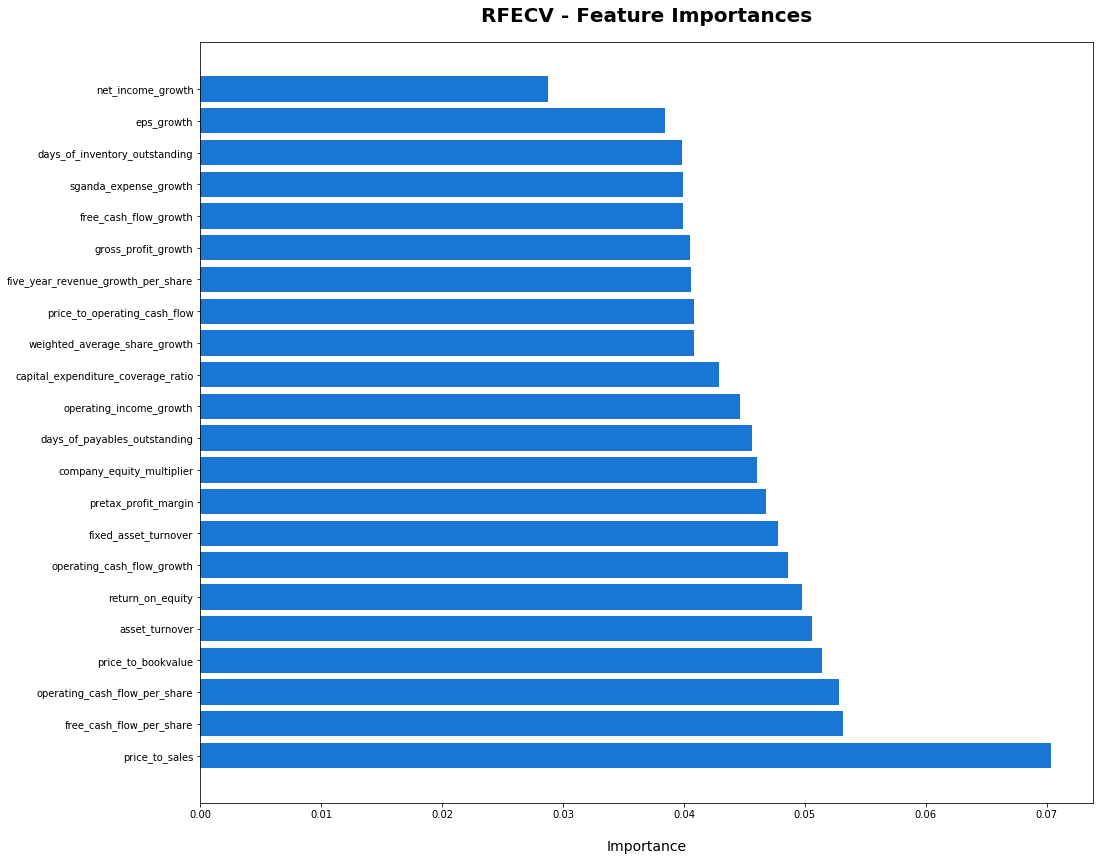

In [13]:
# visualizing the ranking of the features with a horizontal barchart.
dset = pd.DataFrame()
dset['attr'] = X.columns
dset['importance'] = rfecv.estimator_.feature_importances_

dset = dset.sort_values(by='importance', ascending=False)


plt.figure(figsize=(16, 14))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

In [ ]:
# Support vector machine linear classifier
from sklearn.svm import SVC 
model = SVC(kernel='linear')
model.fit(X, target)

In [18]:
 # Split data into training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, target_train, target_test = train_test_split(X, target, random_state=42)

In [19]:
# Fit to the training data and validate with the test data
model = SVC(kernel='linear')
model.fit(X_train, target_train)
predictions = model.predict(X_test)

In [21]:
 # Calculate classification report
from sklearn.metrics import classification_report
print(classification_report(target_test, predictions,
                            target_names=["1", "0"]))

              precision    recall  f1-score   support

           1       0.64      0.47      0.54        59
           0       0.58      0.72      0.64        58

    accuracy                           0.60       117
   macro avg       0.61      0.60      0.59       117
weighted avg       0.61      0.60      0.59       117



In [22]:
target_test.value_counts()

0    59
1    58
Name: above_below_sandp_return, dtype: int64

In [23]:
target.mean()

0.5512820512820513